# NOTES:
Reveal.js
- `spacebar` to traverse slides
- `shift + spacebar` to reverse traverse
- to traverse subslides pgup or pgdown (on mac) -> `fn + down or up arrow`

Markdown
use `two spaces` at the  
end to make a newline or
use `<br>` <br>
or use `\`\
backlash for newline


# Synthetic Population Generation for Reinforcement Learning Policy Simulation

![Social Network](res/graph-network.jpeg "Synthetic Population Network")

Author: Timothy L.J. Stewart\
Department: UWF-IHMC ISR Ph.D. candidate\
Advisors: Dr. Ashok UWF and Dr. Arash IHMC\
The code and writeup: https://tljstewart.github.io/



# Synthetic Population Generation for Reinforcement Learning Policy Simulation

There are many uses for synthetic population generation. Modern usage utilize high performance computing in stochastic simulations to simulate events, such as, disease spread, economics, social modeling, disaster response, catastrophic events and many more. 

In [126]:
%config InlineBackend.figure_format = 'retina'
import jdc
import sys
import os
import pandas as pd
import numpy as np
print(sys.version)

#set random seed to have reproducable random states
random_seed = 42

#set pandas option to view more columns
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

!where python
!python --version
!pip --version
!conda --version
#!pip list
#!conda list
#!python -m pip install --upgrade pip #if you need to upgrade pip

## VERSION OUTPUT BELOW ##
#Python 3.9.4
#pip 21.2.4 (python 3.9)
#conda 4.10.3



3.9.4 (default, Apr  9 2021, 09:32:38) 
[Clang 10.0.0 ]
/Users/tljstewart/miniconda3/envs/ml39/bin/python
/usr/bin/python
Python 3.9.4
pip 21.2.4 from /Users/tljstewart/miniconda3/envs/ml39/lib/python3.9/site-packages/pip (python 3.9)
conda 4.10.3


# Grab all files from data direcotory, *(Path windows/linux agnostic)*

In [127]:
#hide_output
# Build Paths to Data (windows/linux agnostic)
from pathlib import Path

datadir = Path("data/2021-10-04-usa-synthetic-population/data/safegraph/safegraph_open_census_data_2019/data/")
meta_datadir = Path("data/2021-10-04-usa-synthetic-population/data/safegraph/safegraph_open_census_data_2019/metadata/")
data_outdir = Path("data/2021-10-04-usa-synthetic-population/data/out/")
geo_datadir = None
pattern_datadir = None

# Get data files, platform dependent ls
pums_5_year_2019_person_file = Path("data/2021-10-04-usa-synthetic-population/data/pums/5-year/csv_pfl/psam_p12.csv")
census_tract_to_puma_file = Path("data/2021-10-04-usa-synthetic-population/data/pums/2010_Census_Tract_to_2010_PUMA.csv")
display(sys.platform)
if sys.platform == 'win32':
    data_files = os.listdir(datadir)
    meta_files = os.listdir(meta_datadir)
    #display(data_files)
    #display(meta_files)
else:
    # Return list of files in alphanumeric order
    data_files = list(os.popen(f"ls {datadir}"))
    data_files = [file.strip("\n") for file in data_files]
    meta_files = list(os.popen(f"ls {meta_datadir}"))
    meta_files = [file.strip("\n") for file in meta_files]
    #display(data_files)


'darwin'

# Ingest Census CSV Data and Metadata Files with Pandas

In [128]:
#hide_output
#Here is a single file, we could wrap this in a for-loop but perhaps not a great idea as this is a large dataset... TODO: may we will to test the limits...
dict_df = dict()
dict_df[data_files[0]] = pd.read_csv(datadir / data_files[0]) #chunksize=chunk_size)
current_data_df = dict_df[data_files[0]]

print("2019 Census Dataset")
display(current_data_df)

#ls should return files in alphabetic order, but just an extra layer of certainty use this loop to get the description file
dict_meta_df = dict()
for i,f in enumerate(meta_files):
    if(f == "cbg_field_descriptions.csv"):
        dict_meta_df[meta_files[i]] = pd.read_csv(meta_datadir / meta_files[i]) #chunksize=chunk_size)
        current_meta_df = dict_meta_df[meta_files[0]]
        print("2019 Census Metadata")
        display(current_meta_df)
        break


2019 Census Dataset


,census_block_group,B01001e1,B01001m1,B01001e2,B01001m2,B01001e3,B01001m3,B01001e4,B01001m4,B01001e5,B01001m5,B01001e6,B01001m6,B01001e7,B01001m7,B01001e8,B01001m8,B01001e9,B01001m9,B01001e10,B01001m10,B01001e11,B01001m11,B01001e12,B01001m12,B01001e13,B01001m13,B01001e14,B01001m14,B01001e15,B01001m15,B01001e16,B01001m16,B01001e17,B01001m17,B01001e18,B01001m18,B01001e19,B01001m19,B01001e20,B01001m20,B01001e21,B01001m21,B01001e22,B01001m22,B01001e23,B01001m23,B01001e24,B01001m24,B01001e25,B01001m25,B01001e26,B01001m26,B01001e27,B01001m27,B01001e28,B01001m28,B01001e29,B01001m29,B01001e30,B01001m30,B01001e31,B01001m31,B01001e32,B01001m32,B01001e33,B01001m33,B01001e34,B01001m34,B01001e35,B01001m35,B01001e36,B01001m36,B01001e37,B01001m37,B01001e38,B01001m38,B01001e39,B01001m39,B01001e40,B01001m40,B01001e41,B01001m41,B01001e42,B01001m42,B01001e43,B01001m43,B01001e44,B01001m44,B01001e45,B01001m45,B01001e46,B01001m46,B01001e47,B01001m47,B01001e48,B01001m48,B01001e49,B01001m49,B01002e1,B01002m1,B01002e2,B01002m2,B01002e3,B01002m3,B01002Ae1,B01002Am1,B01002Ae2,B01002Am2,B01002Ae3,B01002Am3,B01002Be1,B01002Bm1,B01002Be2,B01002Bm2,B01002Be3,B01002Bm3,B01002Ce1,B01002Cm1,B01002Ce2,B01002Cm2,B01002Ce3,B01002Cm3,B01002De1,B01002Dm1,B01002De2,B01002Dm2,B01002De3,B01002Dm3,B01002Ee1,B01002Em1,B01002Ee2,B01002Em2,B01002Ee3,B01002Em3,B01002Fe1,B01002Fm1,B01002Fe2,B01002Fm2,B01002Fe3,B01002Fm3,B01002Ge1,B01002Gm1,B01002Ge2,B01002Gm2,B01002Ge3,B01002Gm3,B01002He1,B01002Hm1,B01002He2,B01002Hm2,B01002He3,B01002Hm3,B01002Ie1,B01002Im1,B01002Ie2,B01002Im2,B01002Ie3,B01002Im3,B01003e1,B01003m1
0,10010201001,730,222,293,87,10,12,26,25,6,10,9,13,0,12,0,12,0,12,30,31,9,15,30,32,24,23,13,14,21,26,40,34,2,4,4,7,15,15,15,16,19,21,16,25,4,6,0,12,0,12,437,171,7,11,6,9,18,17,34,36,8,13,30,43,6,10,30,44,0,12,30,36,44,38,6,10,8,11,57,57,62,39,5,7,8,9,3,5,25,27,16,17,3,5,16,18,15,23,43.3,11.6,43.4,14.2,40.9,21.5,40.8,12.4,45.0,11.0,37.9,21.1,54.5,28.3,NaN,NaN,54.6,6.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.5,1.8,NaN,NaN,NaN,NaN,40.2,12.5,44.6,15.5,37.9,21.1,NaN,NaN,NaN,NaN,NaN,NaN,730,222
1,10010201002,1263,291,614,148,24,29,29,22,58,34,23,20,57,65,14,16,0,12,34,28,22,19,42,39,30,21,48,44,29,20,71,32,62,43,16,14,0,12,5,8,0,12,14,15,5,8,10,11,21,26,649,170,74,46,25,19,65,54,0,12,0,12,10,15,0,12,37,47,24,24,43,43,49,25,32,32,52,31,67,45,60,43,23,39,11,13,2,5,31,32,31,24,6,9,7,9,0,12,38.2,5.7,35.4,8.5,39.7,8.1,38.3,6.8,35.7,8.4,39.5,7.9,53.8,19.9,51.9,41.6,59.5,15.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.2,6.4,19.6,1.6,NaN,NaN,38.1,6.9,37.0,8.4,38.6,7.5,NaN,NaN,NaN,NaN,NaN,NaN,1263,291
2,10010202001,835,222,393,137,40,37,69,63,16,18,36,37,7,13,0,12,7,11,3,7,12,15,17,20,7,13,24,36,29,27,24,24,28,20,4,9,11,12,14,16,8,12,25,27,12,16,0,12,0,12,442,124,12,19,20,19,21,20,42,39,7,11,0,12,5,8,7,11,31,24,19,19,47,38,55,51,12,13,11,16,21,18,3,6,24,26,14,18,7,10,22,27,40,51,16,21,6,9,38.7,10.0,33.7,20.2,41.6,8.5,34.1,23.4,34.8,36.4,31.4,19.6,41.2,9.1,18.5,54.4,41.5,8.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5,20.6,7.5,20.6,NaN,NaN,34.7,25.3,34.8,36.4,31.9,24.3,65.6,64.9,NaN,NaN,65.6,64.9,835,222
3,10010202002,1124,166,665,132,39,25,46,39,29,23,14,20,8,16,0,12,0,12,42,31,87,43,80,53,47,43,60,48,83,44,65,45,27,22,24,27,3,7,0,12,6,11,0,12,5,9,0,12,0,12,459,92,8,12,9,10,13,14,5,8,0,12,18,19,19,24,14,17,20,16,23,23,16,20,43,39,38,27,41,29,38,33,16,20,29,23,15,17,13,12,20,22,7,10,6,9,48,46,42.9,6.7,34.3,3.5,50.4,8.9,39.6,5.8,39.4,10.5,40.2,6.1,44.1,6.1,33.8,4.3,59.5,14.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.5,16.0,NaN,NaN,NaN,NaN,39.6,5.8,39.4,10.5,40.2,6.1,NaN,NaN,NaN,NaN,NaN,NaN,1124,166
4,10010203001,2774,330,1423,225,20,24,143,84,121,71,27,31,27,29,18,21,16,22,51,44,144,111,143,80,85,56,79,54,95,54,107,68,120,52,38,33,8,14,10,16,20,23,106,65,30

2019 Census Metadata


,table_id,table_number,table_title,table_topics,table_universe,field_level_1,field_level_2,field_level_3,field_level_4,field_level_5,field_level_6,field_level_7,field_level_8,field_level_9,field_level_10
0,B01001e1,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,NaN,NaN,NaN,NaN,NaN,NaN
1,B01001e10,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,Male,22 to 24 years,NaN,NaN,NaN,NaN
2,B01001e11,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,Male,25 to 29 years,NaN,NaN,NaN,NaN
3,B01001e12,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,Male,30 to 34 years,NaN,NaN,NaN,NaN
4,B01001e13,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,Male,35 to 39 years,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8115,C24030m55,C24030,Sex By Industry For The Civilian Employed Popu...,"Age and Sex, Civilian Population, Industry",Civilian employed population 16 years and over,MarginOfError,SEX BY INDUSTRY FOR THE CIVILIAN EMPLOYED POPU...,Civilian employed population 16 years and over,Total,Female,Public administration,NaN,NaN,NaN,NaN
8116,C24030m6,C24030,Sex By Industry For The Civilian Employed Popu...,"Age and Sex, Civilian Population, Industry",Civilian employed population 16 years and over,MarginOfError,SEX BY INDUSTRY FOR THE CIVILIAN EMPLOYED POPU...,Civilian employed population 16 years and over,Total,Male,Construction,NaN,NaN,NaN,NaN
8117,C24030m7,C24030,Sex By Industry For The Civilian Employed Popu...,"Age and Sex, Civilian Population, Industry",Civilian employed population 16 years and over,MarginOfError,SEX BY INDUSTRY FOR THE CIVILIAN EMPLOYED POPU...,Civilian employed population 16 years and over,Total,Male,Manufacturing,NaN,NaN,NaN,NaN
8118,C24030m8,C24030,Sex By Industry For The Civilian Employed Popu...,"Age and Sex, Civilian Population, Industry",Civilian employed population 16 years and over,MarginOfError,SEX BY INDUSTRY FOR THE CIVILIAN EMPLOYED POPU...,Civilian employed population 16 years and over,Total,Male,Wholesale trade,NaN,NaN,NaN,NaN


# Drop all the columns for marginal error, and other unneeded columns

In [129]:
# Find margin of errors
drop_marginoferror_df = current_meta_df[current_meta_df["field_level_1"] == "MarginOfError"]
drop_marginoferror_ls = list(drop_marginoferror_df["table_id"])
keep_meta_df = current_meta_df[current_meta_df["field_level_1"] != "MarginOfError"]

# Drop margin of error, axis=1 drop columns, axis=0 drop rows, axis=0 is default mode
# alternatively, axis='rows' or axis'columns' is the same as axis=0 or axis=1, respectively
thisFilter = current_data_df.filter(drop_marginoferror_ls)
display(thisFilter)
current_data_df.drop(thisFilter, inplace=True, axis=1)

display(current_data_df)
display(current_meta_df)

# Display this to see unique fields in the meta file
unique_meta_df = current_meta_df.apply(lambda col: col.unique())


,B01001m1,B01001m10,B01001m11,B01001m12,B01001m13,B01001m14,B01001m15,B01001m16,B01001m17,B01001m18,B01001m19,B01001m2,B01001m20,B01001m21,B01001m22,B01001m23,B01001m24,B01001m25,B01001m26,B01001m27,B01001m28,B01001m29,B01001m3,B01001m30,B01001m31,B01001m32,B01001m33,B01001m34,B01001m35,B01001m36,B01001m37,B01001m38,B01001m39,B01001m4,B01001m40,B01001m41,B01001m42,B01001m43,B01001m44,B01001m45,B01001m46,B01001m47,B01001m48,B01001m49,B01001m5,B01001m6,B01001m7,B01001m8,B01001m9,B01002Am1,B01002Am2,B01002Am3,B01002Bm1,B01002Bm2,B01002Bm3,B01002Cm1,B01002Cm2,B01002Cm3,B01002Dm1,B01002Dm2,B01002Dm3,B01002Fm1,B01002Fm2,B01002Fm3,B01002Gm1,B01002Gm2,B01002Gm3,B01002Hm1,B01002Hm2,B01002Hm3,B01002Im1,B01002Im2,B01002Im3,B01002m1,B01002m2,B01002m3,B01003m1
0,222,31,15,32,23,14,26,34,4,7,15,87,16,21,25,6,12,12,171,11,9,17,12,36,13,43,10,44,12,36,38,10,11,25,57,39,7,9,5,27,17,5,18,23,10,13,12,12,12,12.4,11.0,21.1,28.3,NaN,6.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,NaN,NaN,12.5,15.5,21.1,NaN,NaN,NaN,11.6,14.2,21.5,222
1,291,28,19,39,21,44,20,32,43,14,12,148,8,12,15,8,11,26,170,46,19,54,29,12,12,15,12,47,24,43,25,32,31,22,45,43,39,13,5,32,24,9,9,12,34,20,65,16,12,6.8,8.4,7.9,19.9,41.6,15.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.4,1.6,NaN,6.9,8.4,7.5,NaN,NaN,NaN,5.7,8.5,8.1,291
2,222,7,15,20,13,36,27,24,20,9,12,137,16,12,27,16,12,12,124,19,19,20,37,39,11,12,8,11,24,19,38,51,13,63,16,18,6,26,18,10,27,51,21,9,18,37,13,12,11,23.4,36.4,19.6,9.1,54.4,8.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.6,20.6,NaN,25.3,36.4,24.3,64.9,NaN,64.9,10.0,20.2,8.5,222
3,166,31,43,53,43,48,44,45,22,27,7,132,12,11,12,9,12,12,92,12,10,14,25,8,12,19,24,17,16,23,20,39,27,39,29,33,20,23,17,12,22,10,9,46,23,20,16,12,12,5.8,10.5,6.1,6.1,4.3,14.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,5.8,10.5,6.1,NaN,NaN,NaN,6.7,3.5,8.9,166
4,330,44,111,80,56,54,54,68,52,33,14,225,16,23,65,26,12,17,194,32,79,69,24,41,8,12,12,32,81,61,77,100,31,84,45,61,23,38,12,23,49,33,31,33,71,31,29,21,22,5.0,4.2,12.9,5.0,15.8,4.3,NaN,NaN,NaN,30.8,NaN,30.8,0.5,0.2,0.4,6.3,5.0,NaN,5.0,4.2,12.9,0.5,0.2,0.4,3.7,5.3,7.1,330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220328,276,27,42,38,23,24,34,23,32,47,24,146,22,15,17,22,28,30,159,46,30,41,42,43,9,12,19,20,31,29,39,32,40,45,27,21,41,34,18,11,22,20,32,18,41,35,12,12,12,6.8,10.1,9.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.4,17.1,6.6,7.0,9.7,9.2,NaN,NaN,NaN,8.6,9.7,9.1,276
220329,277,21,14,65,51,29,50,51,72,47,36,179,23,45,41,21,12,12,160,28,79,68,21,12,17,28,12,12,36,41,61,32,35,30,50,36,13,48,13,15,36,21,53,22,62,12,57,53,4,7.5,7.7,8.9,40.9,40.9,NaN,NaN,NaN,NaN,13.9,13.9,NaN,NaN,NaN,NaN,56.1,56.1,NaN,6.9,9.5,8.9,6.1,6.1,NaN,7.1,7.8,8.9,277
220330,359,12,47,39,59,50,21,34,24,20,22,196,19,10,12,48,14,15,192,46,69,26,40,19,13,12,29,12,42,38,62,61,25,80,20,29,18,29,17,13,14,18,51,18,12,75,20,12,24,6.8,8.0,10.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.8,8.0,10.8,NaN,NaN,NaN,6.5,7.4,10.8,359
220331,254,45,39,29,18,28,19,52,19,22,26,147,15,22,11,34,38,13,164,24,32,43,46,29,14,12,20,39,21,61,19,58,15,27,33,24,10,37,17,21,42,34,20,24,12,43,26,12,28,13.5,17.9,16.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.5,18.2,16.3,NaN,NaN,NaN,14.4,17.9,17.1,254


,census_block_group,B01001e1,B01001e2,B01001e3,B01001e4,B01001e5,B01001e6,B01001e7,B01001e8,B01001e9,B01001e10,B01001e11,B01001e12,B01001e13,B01001e14,B01001e15,B01001e16,B01001e17,B01001e18,B01001e19,B01001e20,B01001e21,B01001e22,B01001e23,B01001e24,B01001e25,B01001e26,B01001e27,B01001e28,B01001e29,B01001e30,B01001e31,B01001e32,B01001e33,B01001e34,B01001e35,B01001e36,B01001e37,B01001e38,B01001e39,B01001e40,B01001e41,B01001e42,B01001e43,B01001e44,B01001e45,B01001e46,B01001e47,B01001e48,B01001e49,B01002e1,B01002e2,B01002e3,B01002Ae1,B01002Ae2,B01002Ae3,B01002Be1,B01002Be2,B01002Be3,B01002Ce1,B01002Ce2,B01002Ce3,B01002De1,B01002De2,B01002De3,B01002Ee1,B01002Em1,B01002Ee2,B01002Em2,B01002Ee3,B01002Em3,B01002Fe1,B01002Fe2,B01002Fe3,B01002Ge1,B01002Ge2,B01002Ge3,B01002He1,B01002He2,B01002He3,B01002Ie1,B01002Ie2,B01002Ie3,B01003e1
0,10010201001,730,293,10,26,6,9,0,0,0,30,9,30,24,13,21,40,2,4,15,15,19,16,4,0,0,437,7,6,18,34,8,30,6,30,0,30,44,6,8,57,62,5,8,3,25,16,3,16,15,43.3,43.4,40.9,40.8,45.0,37.9,54.5,NaN,54.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.5,NaN,NaN,40.2,44.6,37.9,NaN,NaN,NaN,730
1,10010201002,1263,614,24,29,58,23,57,14,0,34,22,42,30,48,29,71,62,16,0,5,0,14,5,10,21,649,74,25,65,0,0,10,0,37,24,43,49,32,52,67,60,23,11,2,31,31,6,7,0,38.2,35.4,39.7,38.3,35.7,39.5,53.8,51.9,59.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.2,19.6,NaN,38.1,37.0,38.6,NaN,NaN,NaN,1263
2,10010202001,835,393,40,69,16,36,7,0,7,3,12,17,7,24,29,24,28,4,11,14,8,25,12,0,0,442,12,20,21,42,7,0,5,7,31,19,47,55,12,11,21,3,24,14,7,22,40,16,6,38.7,33.7,41.6,34.1,34.8,31.4,41.2,18.5,41.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5,7.5,NaN,34.7,34.8,31.9,65.6,NaN,65.6,835
3,10010202002,1124,665,39,46,29,14,8,0,0,42,87,80,47,60,83,65,27,24,3,0,6,0,5,0,0,459,8,9,13,5,0,18,19,14,20,23,16,43,38,41,38,16,29,15,13,20,7,6,48,42.9,34.3,50.4,39.6,39.4,40.2,44.1,33.8,59.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.5,NaN,NaN,39.6,39.4,40.2,NaN,NaN,NaN,1124
4,10010203001,2774,1423,20,143,121,27,27,18,16,51,144,143,85,79,95,107,120,38,8,10,20,106,30,0,15,1351,35,115,99,53,4,0,0,35,101,117,111,123,56,78,154,24,36,0,26,54,68,35,27,37.3,36.3,40.1,37.9,37.6,40.7,41.2,46.1,40.7,NaN,NaN,NaN,33.4,NaN,33.4,NaN,NaN,NaN,NaN,NaN,NaN,27.8,27.5,28.5,10.9,10.6,NaN,37.9,37.6,40.7,27.8,27.5,28.5,2774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220328,560459511001,1450,734,76,44,49,23,0,0,0,18,66,38,27,29,50,20,36,84,26,27,12,20,22,27,40,716,67,24,49,36,6,0,15,16,31,25,44,25,77,36,27,55,46,21,9,31,28,36,12,45.3,43.7,45.6,45.9,46.6,45.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.4,5.6,61.5,45.8,46.2,45.6,NaN,NaN,NaN,1450
220329,560459511002,1844,1116,14,25,64,0,61,46,2,14,23,115,90,44,87,77,133,54,60,24,109,54,20,0,0,728,19,65,48,0,9,20,0,0,29,38,42,22,29,120,59,9,59,12,9,65,20,35,19,50.5,47.3,52.3,50.5,47.3,52.3,55.8,55.8,NaN,NaN,NaN,NaN,64.2,64.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.7,19.7,NaN,51.5,47.9,52.3,33.8,33.8,NaN,1844
220330,560459513001,1314,712,42,98,0,76,15,0,14,0,84,38,85,62,22,28,21,13,23,18,12,0,43,9,9,602,66,70,19,11,8,0,21,0,48,33,54,41,34,13,36,15,31,16,10,8,11,46,11,35.5,34.4,38.3,35.8,34.9,38.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.8,34.9,38.3,NaN,NaN,NaN,1314
220331,560459513002,1164,553,47,17,0,30,15,0,13,54,45,22,11,18,14,81,16,18,30,14,21,7,41,32,7,611,21,29,29,16,8,0,13,40,19,68,10,57,8,37,26,6,31,18,22,60,45,17,31,44.5,45.6,43.8,46.0,45.6,48.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.2,46.0,48.2,NaN,NaN,NaN,1164


,table_id,table_number,table_title,table_topics,table_universe,field_level_1,field_level_2,field_level_3,field_level_4,field_level_5,field_level_6,field_level_7,field_level_8,field_level_9,field_level_10
0,B01001e1,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,NaN,NaN,NaN,NaN,NaN,NaN
1,B01001e10,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,Male,22 to 24 years,NaN,NaN,NaN,NaN
2,B01001e11,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,Male,25 to 29 years,NaN,NaN,NaN,NaN
3,B01001e12,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,Male,30 to 34 years,NaN,NaN,NaN,NaN
4,B01001e13,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,Male,35 to 39 years,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8115,C24030m55,C24030,Sex By Industry For The Civilian Employed Popu...,"Age and Sex, Civilian Population, Industry",Civilian employed population 16 years and over,MarginOfError,SEX BY INDUSTRY FOR THE CIVILIAN EMPLOYED POPU...,Civilian employed population 16 years and over,Total,Female,Public administration,NaN,NaN,NaN,NaN
8116,C24030m6,C24030,Sex By Industry For The Civilian Employed Popu...,"Age and Sex, Civilian Population, Industry",Civilian employed population 16 years and over,MarginOfError,SEX BY INDUSTRY FOR THE CIVILIAN EMPLOYED POPU...,Civilian employed population 16 years and over,Total,Male,Construction,NaN,NaN,NaN,NaN
8117,C24030m7,C24030,Sex By Industry For The Civilian Employed Popu...,"Age and Sex, Civilian Population, Industry",Civilian employed population 16 years and over,MarginOfError,SEX BY INDUSTRY FOR THE CIVILIAN EMPLOYED POPU...,Civilian employed population 16 years and over,Total,Male,Manufacturing,NaN,NaN,NaN,NaN
8118,C24030m8,C24030,Sex By Industry For The Civilian Employed Popu...,"Age and Sex, Civilian Population, Industry",Civilian employed population 16 years and over,MarginOfError,SEX BY INDUSTRY FOR THE CIVILIAN EMPLOYED POPU...,Civilian employed population 16 years and over,Total,Male,Wholesale trade,NaN,NaN,NaN,NaN


# Now `current_meta_df` drops all *MarginOfError* data

In [130]:
current_meta_df = keep_meta_df
display(current_meta_df)

,table_id,table_number,table_title,table_topics,table_universe,field_level_1,field_level_2,field_level_3,field_level_4,field_level_5,field_level_6,field_level_7,field_level_8,field_level_9,field_level_10
0,B01001e1,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,NaN,NaN,NaN,NaN,NaN,NaN
1,B01001e10,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,Male,22 to 24 years,NaN,NaN,NaN,NaN
2,B01001e11,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,Male,25 to 29 years,NaN,NaN,NaN,NaN
3,B01001e12,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,Male,30 to 34 years,NaN,NaN,NaN,NaN
4,B01001e13,B01001,Sex By Age,Age and Sex,Total population,Estimate,SEX BY AGE,Total population,Total,Male,35 to 39 years,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8060,C24030e55,C24030,Sex By Industry For The Civilian Employed Popu...,"Age and Sex, Civilian Population, Industry",Civilian employed population 16 years and over,Estimate,SEX BY INDUSTRY FOR THE CIVILIAN EMPLOYED POPU...,Civilian employed population 16 years and over,Total,Female,Public administration,NaN,NaN,NaN,NaN
8061,C24030e6,C24030,Sex By Industry For The Civilian Employed Popu...,"Age and Sex, Civilian Population, Industry",Civilian employed population 16 years and over,Estimate,SEX BY INDUSTRY FOR THE CIVILIAN EMPLOYED POPU...,Civilian employed population 16 years and over,Total,Male,Construction,NaN,NaN,NaN,NaN
8062,C24030e7,C24030,Sex By Industry For The Civilian Employed Popu...,"Age and Sex, Civilian Population, Industry",Civilian employed population 16 years and over,Estimate,SEX BY INDUSTRY FOR THE CIVILIAN EMPLOYED POPU...,Civilian employed population 16 years and over,Total,Male,Manufacturing,NaN,NaN,NaN,NaN
8063,C24030e8,C24030,Sex By Industry For The Civilian Employed Popu...,"Age and Sex, Civilian Population, Industry",Civilian employed population 16 years and over,Estimate,SEX BY INDUSTRY FOR THE CIVILIAN EMPLOYED POPU...,Civilian employed population 16 years and over,Total,Male,Wholesale trade,NaN,NaN,NaN,NaN


# Write a Labels CSV to Disk

In [131]:
#hide_output
#sum on 0 axis... sum down the rows (i.e., sum a whole column) axis 1 sum across the columns (i.e, sum a whole row)
df_totals = current_data_df.sum(axis='rows', skipna = True)
print(df_totals.shape)
print(current_data_df.columns)
tmp_df = pd.DataFrame(current_data_df.columns)
display(tmp_df.values)

#write to csv
tmp_df.to_csv(data_outdir / "84labels.csv", index=False, header=False)


(84,)
Index(['census_block_group', 'B01001e1', 'B01001e2', 'B01001e3', 'B01001e4', 'B01001e5', 'B01001e6', 'B01001e7', 'B01001e8', 'B01001e9', 'B01001e10', 'B01001e11', 'B01001e12', 'B01001e13', 'B01001e14', 'B01001e15', 'B01001e16', 'B01001e17', 'B01001e18', 'B01001e19', 'B01001e20', 'B01001e21', 'B01001e22', 'B01001e23', 'B01001e24', 'B01001e25', 'B01001e26', 'B01001e27', 'B01001e28', 'B01001e29', 'B01001e30', 'B01001e31', 'B01001e32', 'B01001e33', 'B01001e34', 'B01001e35', 'B01001e36', 'B01001e37', 'B01001e38', 'B01001e39', 'B01001e40', 'B01001e41', 'B01001e42', 'B01001e43', 'B01001e44', 'B01001e45', 'B01001e46', 'B01001e47', 'B01001e48', 'B01001e49', 'B01002e1', 'B01002e2', 'B01002e3', 'B01002Ae1', 'B01002Ae2', 'B01002Ae3', 'B01002Be1', 'B01002Be2', 'B01002Be3', 'B01002Ce1', 'B01002Ce2', 'B01002Ce3', 'B01002De1', 'B01002De2', 'B01002De3', 'B01002Ee1', 'B01002Em1', 'B01002Ee2', 'B01002Em2', 'B01002Ee3', 'B01002Em3', 'B01002Fe1', 'B01002Fe2', 'B01002Fe3', 'B01002Ge1', 'B01002Ge2', 'B

array([['census_block_group'],
       ['B01001e1'],
       ['B01001e2'],
       ['B01001e3'],
       ['B01001e4'],
       ['B01001e5'],
       ['B01001e6'],
       ['B01001e7'],
       ['B01001e8'],
       ['B01001e9'],
       ['B01001e10'],
       ['B01001e11'],
       ['B01001e12'],
       ['B01001e13'],
       ['B01001e14'],
       ['B01001e15'],
       ['B01001e16'],
       ['B01001e17'],
       ['B01001e18'],
       ['B01001e19'],
       ['B01001e20'],
       ['B01001e21'],
       ['B01001e22'],
       ['B01001e23'],
       ['B01001e24'],
       ['B01001e25'],
       ['B01001e26'],
       ['B01001e27'],
       ['B01001e28'],
       ['B01001e29'],
       ['B01001e30'],
       ['B01001e31'],
       ['B01001e32'],
       ['B01001e33'],
       ['B01001e34'],
       ['B01001e35'],
       ['B01001e36'],
       ['B01001e37'],
       ['B01001e38'],
       ['B01001e39'],
       ['B01001e40'],
       ['B01001e41'],
       ['B01001e42'],
       ['B01001e43'],
       ['B01001e44'],
       ['B

# Rename `current_data_df` Columns 
Rename `current_data_df` columns `b0xxxx` -> `newlabels_list`

In [132]:
tmp_df = current_meta_df[current_meta_df.table_id.isin(list(current_data_df.columns))].copy()
tmp_missing_df = current_meta_df[~current_meta_df.table_id.isin(list(current_data_df.columns))]
tmp_df.fillna('', inplace=True)
t = tmp_df[["field_level_2", "field_level_3", "field_level_4", "field_level_5", "field_level_6"]]
newlabels_list = list(t["field_level_2"] + " " + t["field_level_3"] + " " + t["field_level_4"] + " " + t["field_level_5"] + " " + t["field_level_6"])

newlabels_list = [x.strip() for x in newlabels_list]
newlabels_list = [x.strip('"') for x in newlabels_list]
newlabels_list = [x.replace(',',"") for x in newlabels_list]
newlabels_list = [x.replace(")","") for x in newlabels_list]
newlabels_list = [x.replace("(","") for x in newlabels_list]
newlabels_list = [x.replace(" ","_") for x in newlabels_list]
tmp_list = list(tmp_df.table_id)
newlabels_dict = dict(zip(tmp_list, newlabels_list))

cell_ran = False
if cell_ran is False:
    cell_ran = True
    current_data_df.rename(columns=newlabels_dict, inplace=True)

current_data_df

,census_block_group,SEX_BY_AGE_Total_population_Total,SEX_BY_AGE_Total_population_Total_Male,SEX_BY_AGE_Total_population_Total_Male_Under_5_years,SEX_BY_AGE_Total_population_Total_Male_5_to_9_years,SEX_BY_AGE_Total_population_Total_Male_10_to_14_years,SEX_BY_AGE_Total_population_Total_Male_15_to_17_years,SEX_BY_AGE_Total_population_Total_Male_18_and_19_years,SEX_BY_AGE_Total_population_Total_Male_20_years,SEX_BY_AGE_Total_population_Total_Male_21_years,SEX_BY_AGE_Total_population_Total_Male_22_to_24_years,SEX_BY_AGE_Total_population_Total_Male_25_to_29_years,SEX_BY_AGE_Total_population_Total_Male_30_to_34_years,SEX_BY_AGE_Total_population_Total_Male_35_to_39_years,SEX_BY_AGE_Total_population_Total_Male_40_to_44_years,SEX_BY_AGE_Total_population_Total_Male_45_to_49_years,SEX_BY_AGE_Total_population_Total_Male_50_to_54_years,SEX_BY_AGE_Total_population_Total_Male_55_to_59_years,SEX_BY_AGE_Total_population_Total_Male_60_and_61_years,SEX_BY_AGE_Total_population_Total_Male_62_to_64_years,SEX_BY_AGE_Total_population_Total_Male_65_and_66_years,SEX_BY_AGE_Total_population_Total_Male_67_to_69_years,SEX_BY_AGE_Total_population_Total_Male_70_to_74_years,SEX_BY_AGE_Total_population_Total_Male_75_to_79_years,SEX_BY_AGE_Total_population_Total_Male_80_to_84_years,SEX_BY_AGE_Total_population_Total_Male_85_years_and_over,SEX_BY_AGE_Total_population_Total_Female,SEX_BY_AGE_Total_population_Total_Female_Under_5_years,SEX_BY_AGE_Total_population_Total_Female_5_to_9_years,SEX_BY_AGE_Total_population_Total_Female_10_to_14_years,SEX_BY_AGE_Total_population_Total_Female_15_to_17_years,SEX_BY_AGE_Total_population_Total_Female_18_and_19_years,SEX_BY_AGE_Total_population_Total_Female_20_years,SEX_BY_AGE_Total_population_Total_Female_21_years,SEX_BY_AGE_Total_population_Total_Female_22_to_24_years,SEX_BY_AGE_Total_population_Total_Female_25_to_29_years,SEX_BY_AGE_Total_population_Total_Female_30_to_34_years,SEX_BY_AGE_Total_population_Total_Female_35_to_39_years,SEX_BY_AGE_Total_population_Total_Female_40_to_44_years,SEX_BY_AGE_Total_population_Total_Female_45_to_49_years,SEX_BY_AGE_Total_population_Total_Female_50_to_54_years,SEX_BY_AGE_Total_population_Total_Female_55_to_59_years,SEX_BY_AGE_Total_population_Total_Female_60_and_61_years,SEX_BY_AGE_Total_population_Total_Female_62_to_64_years,SEX_BY_AGE_Total_population_Total_Female_65_and_66_years,SEX_BY_AGE_Total_population_Total_Female_67_to_69_years,SEX_BY_AGE_Total_population_Total_Female_70_to_74_years,SEX_BY_AGE_Total_population_Total_Female_75_to_79_years,SEX_BY_AGE_Total_population_Total_Female_80_to_84_years,SEX_BY_AGE_Total_population_Total_Female_85_years_and_over,MEDIAN_AGE_BY_SEX_Total_population_Median_age_Total,MEDIAN_AGE_BY_SEX_Total_population_Median_age_Male,MEDIAN_AGE_BY_SEX_Total_population_Median_age_Female,MEDIAN_AGE_BY_SEX_WHITE_ALONE_People_who_are_White_alone_Median_age_Total,MEDIAN_AGE_BY_SEX_WHITE_ALONE_People_who_are_White_alone_Median_age_Male,MEDIAN_AGE_BY_SEX_WHITE_ALONE_People_who_are_White_alone_Median_age_Female,MEDIAN_AGE_BY_SEX_BLACK_OR_AFRICAN_AMERICAN_ALONE_Black_or_African_American_alone_Median_age_Total,MEDIAN_AGE_BY_SEX_BLACK_OR_AFRICAN_AMERICAN_ALONE_Black_or_African_American_alone_Median_age_Male,MEDIAN_AGE_BY_SEX_BLACK_OR_AFRICAN_AMERICAN_ALONE_Black_or_African_American_alone_Median_age_Female,MEDIAN_AGE_BY_SEX_AMERICAN_INDIAN_AND_ALASKA_NATIVE_ALONE_People_who_are_American_Indian_and_Alaska_Native_alone_Median_age_Total,MEDIAN_AGE_BY_SEX_AMERICAN_INDIAN_AND_ALASKA_NATIVE_ALONE_People_who_are_American_Indian_and_Alaska_Native_alone_Median_age_Male,MEDIAN_AGE_BY_SEX_AMERICAN_INDIAN_AND_ALASKA_NATIVE_ALONE_People_who_are_American_Indian_and_Alaska_Native_alone_Median_age_Female,MEDIAN_AGE_BY_SEX_ASIAN_ALONE_People_who_are_Asian_alone_Median_age_Total,MEDIAN_AGE_BY_SEX_ASIAN_ALONE_People_who_are_Asian_alone_Median_age_Male,MEDIAN_AGE_BY_SEX_ASIAN_ALONE_People_who_are_Asian_alone_Median_age_Female,B01002Ee1,B01002Em1,B01002Ee2,B01002Em2,B01002Ee3,B01002Em3,MEDIAN_

# Generate Simplifed Meta CSV File 
Map `table_id` `B0xxxxx` values to a `simple-meta-all-labels.csv` file

In [133]:
simple_meta_df = pd.DataFrame(current_meta_df.table_id.copy())
tmp_df = current_meta_df.fillna('')

all_labels_list = list(tmp_df.field_level_2 + " " + tmp_df.field_level_3 + " " + tmp_df.field_level_4 + " " + tmp_df.field_level_5 + " " + tmp_df.field_level_6 + " " + tmp_df.field_level_7 + " " + tmp_df.field_level_8 + " " + tmp_df.field_level_9 + " " + tmp_df.field_level_10)
all_labels_list = [x.strip() for x in all_labels_list]
all_labels_list = [x.strip('"') for x in all_labels_list]
all_labels_list = [x.replace(',',"") for x in all_labels_list]
all_labels_list = [x.replace(")","") for x in all_labels_list]
all_labels_list = [x.replace("(","") for x in all_labels_list]
all_labels_list = [x.replace(" ","_") for x in all_labels_list]

simple_meta_df.insert(loc=1, column='simple_meta', value=all_labels_list)
simple_meta_df.sort_values("table_id", inplace=True)
simple_meta_df.to_csv(data_outdir / "simple-meta-all-labels.csv", index=False)


# Population Generator Class

In [134]:
# Build population generator class
from scipy.stats import multinomial

class PopulationGenerator():
    """
    A population generator class based on census distribution data

    Parameters:
        census_block_group (list-like) optional: 1 or more census block groups in a list, can be exact cbg or parital to match all 'like'
        year (int): 4 digit integer year

    Returns:
        PopulationGenerator Object: Returning value
    """

    def __init__(self, census_block_group=None, year=0000, like=False):
        self.census_block_group = census_block_group
        self.year = year
        #TODO: house df of interest here?
        # self.current_data_df
        # self.current_meta_df
        self. _df = pd.DataFrame()
        self.gender_age_labels = list()
        self._count = -1  
        

    @property
    def count(self):
        """Getter Method"""
        self._count += 1
        return self._count

    # @count.setter
    # def count(self):
    #     self._count = 
    
    def selectData(self):
        pass

    def cleanData(self):
        pass

In [135]:
    %%add_to PopulationGenerator    
    def getGenderAge(self, census_block_group=None):
        #get only gender and age
        gender_age_df = current_data_df.filter(like="SEX_BY_AGE")
        #print(gender_age_df)


        #get labels for data
        gender_age_labels = list(gender_age_df.columns)


        #add census_block_group to labels so we can filter the df and use census_block_group as index
        gender_age_labels.insert(0, "census_block_group")
        #display(gender_age_labels)


        #use census_block_group as index
        gender_age_df = current_data_df.filter(gender_age_labels)
        gender_age_df.set_index("census_block_group", inplace=True)
        #display(gender_age_df)


        #make labels a one-to-one map to label gender_age_probList
        remove_labels = ["census_block_group","SEX_BY_AGE_Total_population_Total_Male", "SEX_BY_AGE_Total_population_Total_Female", "SEX_BY_AGE_Total_population_Total"]
        for d in remove_labels:
            gender_age_labels.remove(d)
        #display(gender_age_labels)


        #build probility list for multinomial distribution
        gender_age_probList = list()
        for x in gender_age_labels:
            #print(x)
            gender_age_probList.append(gender_age_df.at[census_block_group, x]/gender_age_df.SEX_BY_AGE_Total_population_Total.at[census_block_group])

        #must be same length
        assert(len(gender_age_probList) == len(gender_age_labels))
        self.gender_age_df = gender_age_df
        self.gender_age_labels = gender_age_labels
        return gender_age_probList, gender_age_labels

In [136]:
    %%add_to PopulationGenerator  
    def generatePopulation(self, population_size, census_block_group=None, like=False):
        """
        Generators population based on params

        Parameters:
            population_size (int): population size of each census_block_group in list
            census_block_group (list-like) optional: census block groups, overide class self.census_block_group

        Returns:
            population (list): Returns a list of Persons() generated
        """
        population = list()

        if like is True:
            #create a list... from 'like' first numbers in census_block_group in gender_age_df... scoop for gender_age_df is in other function
            pass
        if census_block_group is None and self.census_block_group is None:
            print("Please Provide census_block_group Param")
        elif census_block_group is None:
            cbg = self.census_block_group
        else:
            cbg = census_block_group
            
        for c in cbg:
            gender_age_probList, gender_age_labels = self.getGenderAge(census_block_group=c)
            rv_gender_age = multinomial.rvs(population_size, gender_age_probList) 
            print(f'\n[i] Generated Population:\n{rv_gender_age}\n[i] Labels:\n{gender_age_labels}\n[i] Block Group:\n{c}\n[i] Probibility List:\n{gender_age_probList}\n[i] Population Size:\n{population_size}\n')
            for i,x in enumerate(rv_gender_age): 
                [population.append(Person(gender_age=gender_age_labels[i], census_block_group=c, uuid=self.count)) for _ in range(x)]
        
            #assert(len(population) == population_size)
        print(len(population))
        return population


    

# Person Class

In [137]:
# Build Person Class

class Person():
    """
    A basic person class to hold census distribution data
    """

    def __init__(self, uuid, gender_age=None, race=None, height=None, weight=None, census_block_group=None):
        self.baseline = { #sampleFromJointDistribution() https://data.census.gov/cedsci/table?q=United%20States&tid=ACSDP1Y2019.DP05
            'gender_age': gender_age,
            'race': race,
            'height': height, #meters
            'weight': weight, #kg
            'census_block_group' : census_block_group,
            'uuid' : uuid
        }
        self.activity = {}
        self.location = {}
        self.exposure = {}
        self.mobility = {}

        #Reinforcement Learning Parameters
        self.state = None
        self.observation = None


# Randomly Sample Census Distribution using PopulationGenerator Class

This function will return a population of 100 individuals from two census block groups in Pensacola, Florida. Census Block Group 120330036071 is the University of West Florida Campus in Pensacola and Census Block Group 12033000100 is Downtown Pensacola.

**Census Block Group 120330036071, University of West Florida**

![University of West Florida](res/cbg-120330036071-census-2019-pcola-fl.png "Census Block Group 120330036071, University of West Florida")

**Census Block Group 12033000100, Downtown Pensacola**

![Downtown Pensacola](res/cbg-12033000100-census-2019-pcola-fl.png "Census Block Group 12033000100, Downtown Pensacola")

In [138]:
pg = PopulationGenerator()

local_population = pg.generatePopulation(population_size=100, census_block_group=[120330001001, 120330036071])
local_population[0].baseline   


[i] Generated Population:
[ 1  3  0  1  0  0  2  5  3  0  4  2  6  6  5  6  5  0  2  1  4  0  0  1
  1  4  3  0  1  0  2  2 11  0  1  2  2  4  0  0  0  3  2  0  0  5]
[i] Labels:
['SEX_BY_AGE_Total_population_Total_Male_Under_5_years', 'SEX_BY_AGE_Total_population_Total_Male_5_to_9_years', 'SEX_BY_AGE_Total_population_Total_Male_10_to_14_years', 'SEX_BY_AGE_Total_population_Total_Male_15_to_17_years', 'SEX_BY_AGE_Total_population_Total_Male_18_and_19_years', 'SEX_BY_AGE_Total_population_Total_Male_20_years', 'SEX_BY_AGE_Total_population_Total_Male_21_years', 'SEX_BY_AGE_Total_population_Total_Male_22_to_24_years', 'SEX_BY_AGE_Total_population_Total_Male_25_to_29_years', 'SEX_BY_AGE_Total_population_Total_Male_30_to_34_years', 'SEX_BY_AGE_Total_population_Total_Male_35_to_39_years', 'SEX_BY_AGE_Total_population_Total_Male_40_to_44_years', 'SEX_BY_AGE_Total_population_Total_Male_45_to_49_years', 'SEX_BY_AGE_Total_population_Total_Male_50_to_54_years', 'SEX_BY_AGE_Total_population_Total_

{'gender_age': 'SEX_BY_AGE_Total_population_Total_Male_Under_5_years',
 'race': None,
 'height': None,
 'weight': None,
 'census_block_group': 120330001001,
 'uuid': 0}

# Histogram Gender and Age Joint Distributions across entire United States

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
      

#set style
sns.set_theme(style="darkgrid", palette="twilight_shifted_r")
sns.set(rc={"figure.figsize": (12, 8)})

#plot histogram data
tmp_df = pg.gender_age_df.drop(columns=["SEX_BY_AGE_Total_population_Total_Male", "SEX_BY_AGE_Total_population_Total_Female", "SEX_BY_AGE_Total_population_Total"])

tmp_male_df = tmp_df.iloc[:, :23]
tmp_female_df = tmp_df.iloc[:,23:]
tmp_male_dfT = tmp_male_df.T
tmp_female_dfT = tmp_female_df.T
tmp_male_dfT_sum = pd.DataFrame(tmp_male_dfT.sum(axis=1))
tmp_female_dfT_sum = pd.DataFrame(tmp_female_dfT.sum(axis=1))
age_bins = [5, 9, 14, 17, 19, 20, 21, 24, 29, 34, 39, 44, 49, 54, 59, 61, 64, 66, 69, 74, 79, 84, 85]
tmp_male_dfT_sum['age'] = age_bins
tmp_female_dfT_sum['age'] = age_bins
tmp_male_dfT_sum.rename(columns={0:'count'}, inplace=True)
tmp_female_dfT_sum.rename(columns={0:'count'}, inplace=True)
display(tmp_male_dfT_sum)
display(tmp_female_dfT_sum)



,count,age
SEX_BY_AGE_Total_population_Total_Male_Under_5_years,10186190,5
SEX_BY_AGE_Total_population_Total_Male_5_to_9_years,10365772,9
SEX_BY_AGE_Total_population_Total_Male_10_to_14_years,10809850,14
SEX_BY_AGE_Total_population_Total_Male_15_to_17_years,6495599,17
SEX_BY_AGE_Total_population_Total_Male_18_and_19_years,4457762,19
SEX_BY_AGE_Total_population_Total_Male_20_years,2377560,20
SEX_BY_AGE_Total_population_Total_Male_21_years,2328803,21
SEX_BY_AGE_Total_population_Total_Male_22_to_24_years,6706806,24
SEX_BY_AGE_Total_population_Total_Male_25_to_29_years,11846970,29
SEX_BY_AGE_Total_population_Total_Male_30_to_34_years,11166293,34


,count,age
SEX_BY_AGE_Total_population_Total_Female_Under_5_years,9725103,5
SEX_BY_AGE_Total_population_Total_Female_5_to_9_years,9966912,9
SEX_BY_AGE_Total_population_Total_Female_10_to_14_years,10316936,14
SEX_BY_AGE_Total_population_Total_Female_15_to_17_years,6211376,17
SEX_BY_AGE_Total_population_Total_Female_18_and_19_years,4265035,19
SEX_BY_AGE_Total_population_Total_Female_20_years,2237333,20
SEX_BY_AGE_Total_population_Total_Female_21_years,2194387,21
SEX_BY_AGE_Total_population_Total_Female_22_to_24_years,6402783,24
SEX_BY_AGE_Total_population_Total_Female_25_to_29_years,11443595,29
SEX_BY_AGE_Total_population_Total_Female_30_to_34_years,10986753,34


[Text(0.5, 0, 'Age Bins'), Text(0.5, 1.0, 'Female Population by Age')]

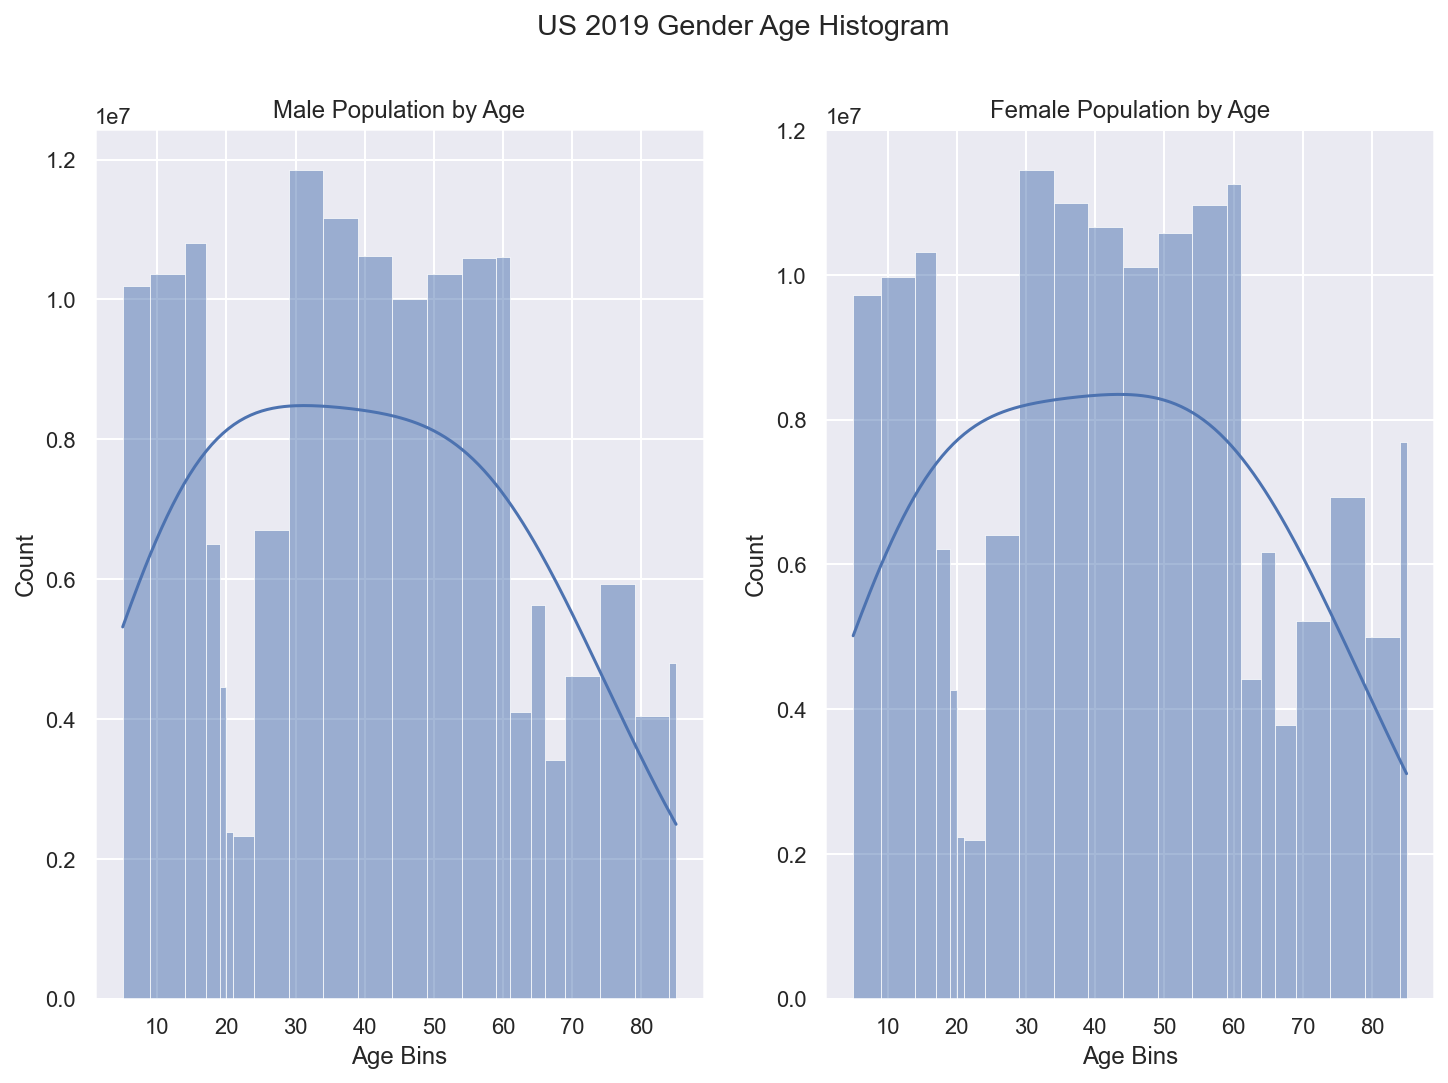

In [140]:
fig, (axm, axf) = plt.subplots(1, 2)
fig.suptitle('US 2019 Gender Age Histogram')

#Plot histogram for Male
sns.histplot(ax=axm, x=age_bins, weights=list(tmp_male_dfT_sum["count"]), bins=age_bins, kde=True)
axm.set(xlabel='Age Bins', title='Male Population by Age')

#Plot histogram for Females
sns.histplot(ax=axf, x=age_bins, weights=list(tmp_female_dfT_sum["count"]), bins=age_bins, kde=True)
axf.set(xlabel='Age Bins', title='Female Population by Age')

In the above plot one can see the gender and age distribution across the United States as recorded by the 2019 Census, it has a mixture of distributions with drop offs in the 20-30 range and great that age 60 range.

# Read in Census Block Group into PUMA Files

* census tract code is 11 digits, appending last digit identifies a unique census block group (cbg)
* all cbg that is part of a census tract (ct) is also part of the associated puma
* puma are relatively large landmass areas compared to tracts and cbg, no less than 100,000 people

In [141]:
#load csv
#keep leading zeros in csv, later strip for STATEFP
dtype_dic = {'STATEFP' : str,
             'COUNTYFP' : str,
             'TRACTCE' : str,
             'PUMA5CE' : str}

#read in puma ct map file with dtype str
ct_puma_df = pd.read_csv(census_tract_to_puma_file, dtype=dtype_dic) #, index_col='STATEFP')

# strip leading zero for 'STATEFP' and 'full_fips_ct to match census_block_group in census csv coding
ct_puma_df.STATEFP = ct_puma_df.STATEFP.str.lstrip('0')


# Map Census Block Group into PUMA

The Public Use Microdata Sample (PUMS) is a 1-Year and 5-Year dataset from the Census Bureau's, this will be used to estimate a joint distribution of age, gender and race.

* pensacola metro area is puma 03301 and 03302
* pensacola metro area census tracts are 120330
* escambia county is state code 12 + county code 033 making 12,033 in ct to puma csv and puma 3301

In [142]:
#PUMA Codes are not universally unique, must have state code
florida_state_fips_code = "12"
pensacola_metro_df = ct_puma_df[((ct_puma_df["PUMA5CE"] == "03301") | (ct_puma_df["PUMA5CE"] == "03302")) & (ct_puma_df.STATEFP == "12")].copy() #make .copy() to squalsh view warning messages
pensacola_metro_df["full_fips_ct"] = pensacola_metro_df.STATEFP + pensacola_metro_df.COUNTYFP + pensacola_metro_df.TRACTCE
pensacola_metro_df.to_csv(data_outdir / "pensacola-metro-area-2010-census-tract-to-2010-puma.csv", index=False)


#get a list of census tracts from pensacola metro area
full_fips_ct_list = list(pensacola_metro_df.full_fips_ct)

tmp_pg_df = pg.gender_age_df
tmp_pg_df['census_block_group'] = pg.gender_age_df.index
tmp_pg_df['census_block_group'] = tmp_pg_df.census_block_group.astype("string") #convert column to "string" not str...

found_pcola_cbg_df = pd.DataFrame()
found_pcola_cbg_df = pd.concat([tmp_pg_df[tmp_pg_df.census_block_group.str.contains(ct)] for ct in full_fips_ct_list])

print("All Census Block Groups that make up Escambia County")
display(found_pcola_cbg_df)

All Census Block Groups that make up Escambia County


,SEX_BY_AGE_Total_population_Total,SEX_BY_AGE_Total_population_Total_Male,SEX_BY_AGE_Total_population_Total_Male_Under_5_years,SEX_BY_AGE_Total_population_Total_Male_5_to_9_years,SEX_BY_AGE_Total_population_Total_Male_10_to_14_years,SEX_BY_AGE_Total_population_Total_Male_15_to_17_years,SEX_BY_AGE_Total_population_Total_Male_18_and_19_years,SEX_BY_AGE_Total_population_Total_Male_20_years,SEX_BY_AGE_Total_population_Total_Male_21_years,SEX_BY_AGE_Total_population_Total_Male_22_to_24_years,SEX_BY_AGE_Total_population_Total_Male_25_to_29_years,SEX_BY_AGE_Total_population_Total_Male_30_to_34_years,SEX_BY_AGE_Total_population_Total_Male_35_to_39_years,SEX_BY_AGE_Total_population_Total_Male_40_to_44_years,SEX_BY_AGE_Total_population_Total_Male_45_to_49_years,SEX_BY_AGE_Total_population_Total_Male_50_to_54_years,SEX_BY_AGE_Total_population_Total_Male_55_to_59_years,SEX_BY_AGE_Total_population_Total_Male_60_and_61_years,SEX_BY_AGE_Total_population_Total_Male_62_to_64_years,SEX_BY_AGE_Total_population_Total_Male_65_and_66_years,SEX_BY_AGE_Total_population_Total_Male_67_to_69_years,SEX_BY_AGE_Total_population_Total_Male_70_to_74_years,SEX_BY_AGE_Total_population_Total_Male_75_to_79_years,SEX_BY_AGE_Total_population_Total_Male_80_to_84_years,SEX_BY_AGE_Total_population_Total_Male_85_years_and_over,SEX_BY_AGE_Total_population_Total_Female,SEX_BY_AGE_Total_population_Total_Female_Under_5_years,SEX_BY_AGE_Total_population_Total_Female_5_to_9_years,SEX_BY_AGE_Total_population_Total_Female_10_to_14_years,SEX_BY_AGE_Total_population_Total_Female_15_to_17_years,SEX_BY_AGE_Total_population_Total_Female_18_and_19_years,SEX_BY_AGE_Total_population_Total_Female_20_years,SEX_BY_AGE_Total_population_Total_Female_21_years,SEX_BY_AGE_Total_population_Total_Female_22_to_24_years,SEX_BY_AGE_Total_population_Total_Female_25_to_29_years,SEX_BY_AGE_Total_population_Total_Female_30_to_34_years,SEX_BY_AGE_Total_population_Total_Female_35_to_39_years,SEX_BY_AGE_Total_population_Total_Female_40_to_44_years,SEX_BY_AGE_Total_population_Total_Female_45_to_49_years,SEX_BY_AGE_Total_population_Total_Female_50_to_54_years,SEX_BY_AGE_Total_population_Total_Female_55_to_59_years,SEX_BY_AGE_Total_population_Total_Female_60_and_61_years,SEX_BY_AGE_Total_population_Total_Female_62_to_64_years,SEX_BY_AGE_Total_population_Total_Female_65_and_66_years,SEX_BY_AGE_Total_population_Total_Female_67_to_69_years,SEX_BY_AGE_Total_population_Total_Female_70_to_74_years,SEX_BY_AGE_Total_population_Total_Female_75_to_79_years,SEX_BY_AGE_Total_population_Total_Female_80_to_84_years,SEX_BY_AGE_Total_population_Total_Female_85_years_and_over,census_block_group
census_block_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
120330011031,933,407,13,66,61,14,0,0,0,10,21,20,20,42,19,37,11,13,11,0,5,19,13,0,12,526,10,20,66,16,0,0,12,26,43,43,49,24,30,32,7,26,40,14,0,13,37,6,12,120330011031
120330011032,1635,682,35,18,81,0,19,0,0,22,44,34,25,24,43,36,86,31,47,24,17,42,6,16,32,953,39,79,87,49,0,24,37,40,24,66,58,15,67,28,97,60,50,31,18,24,13,27,20,120330011032
120330032031,1103,483,0,78,0,0,0,22,0,0,0,21,16,25,51,30,28,31,42,13,34,8,30,35,19,620,0,49,56,0,19,0,0,19,15,32,5,17,7,7,8,25,24,9,42,27,67,94,98,120330032031
120330032032,2793,1262,113,0,111,21,8,0,17,39,92,15,21,106,82,172,110,46,98,55,30,71,30,25,0,1531,90,57,27,35,14,1,56,138,77,33,86,0,106,229,52,62,69,55,85,121,65,52,21,120330032032
120330032033,1006,505,18,41,76,0,0,0,0,10,18,20,15,24,36,9,0,0,44,3,49,37,58,33,14,501,16,46,0,16,0,0,0,0,0,8,29,18,11,16,22,11,28,20,61,23,55,51,70,120330032033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120330033091,1078,389,111,0,0,0,15,0,0,0,22,53,0,0,0,102,0,60,26,0,0,0,0,0,0,689,0,138,86,0,16,44,0,0,22,81,0,0,128,39,0,0,29,0,0,30,63,0,13,120330033091
120330033092,2109,875,44,40,99,0,24,19,0,0,16,63,57,156,116,102,67,0,0,13,12,47,0,0,0,

In the above output one can see all Census Block Groups that make up Escambia County, which map directly to the 2 PUMA areas in Escambia County.

# Assign PUMA to `found_pcola_cbg_df`
**TODO:** 
* may need to redo concat loop....need to add column `PUMA5CE`
* read in 5 years pums, drop all columns except puma, pw weights, age and race columns.

In [143]:
print(f'Population of Pensacola Metro per Census 2019: {found_pcola_cbg_df.SEX_BY_AGE_Total_population_Total.sum()}')

Population of Pensacola Metro per Census 2019: 313491


# USA Total Population,  Compare 1 Year PUMs, 5 Year PUMs and the 2019 Census

There is a 1 year and 5 year pums.

After mapping all Pensacola Metro cbg to the puma. A quick total population summation is as follows:

### Total Population: 1-year pums, psam_p12.csv, PUMA 3301 and 3302 Weighted Population (PWGTP) is

> Note: **Pensacola Metro Area: 317,794**


### Total Population: 5-year pums total population:

> Note: **Pensacola Metro Area: 313,542**


### Total Population: 2019 Census

> Note: **Pensacola Metro Area: 313,491**

# Synthetic Population Generation for Reinforcement Learning Policy Simulation

![Social Network](res/graph-network.jpeg "Synthetic Population Network")

Author: Timothy L.J. Stewart  
Department: UWF-IHMC ISR Ph.D. candidate  
Advisors: Dr. Ashok UWF and Dr. Arash IHMC  
The code and writeup: https://tljstewart.github.io/  
